In [1]:
%matplotlib inline
!pip install oresapi pandas mwtypes mwapi

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import csv
import json
import time
import sys

import oresapi
import mwapi
import mwtypes
import pandas

# Getting an article quality prediction
Article quality in Wikipedia is measured on an ordinal scale: Stub, Start, C, B, GA, FA where "GA" stands for "Good Article" and "FA" stands for "Featured article".  ORES provides an "article quality" model that you can use to get a prediction of where an article is on this scale.  For example, let's get a prediction for a [recent version](https://en.wikipedia.org/w/index.php?title=Ann_Bishop_(biologist%29&oldid=936742440) of the article about [Ann Bishop](https://en.wikipedia.org/wiki/Ann_Bishop_(biologist%29) -- a notable biologist.  

In [3]:
ua = "sgeiger@ucsd.edu -- ORES overview -- Article Quality"
ores_session = oresapi.Session(
    "https://ores.wikimedia.org",
    user_agent=ua)
list(ores_session.score('enwiki', ['articlequality'], 936742440))

[{'articlequality': {'score': {'prediction': 'FA',
    'probability': {'B': 0.042164244699203435,
     'C': 0.021921980057550028,
     'FA': 0.586778699843404,
     'GA': 0.33866693096308614,
     'Start': 0.007535970555858138,
     'Stub': 0.0029321738808980656}}}}]

In the above output, we can see that ORES predicts that the article is of "FA" (Featured Article) status with high certainty (64%), but it might be "GA" (Good Article) status with lower certainty (29%).  

Let's try answering a question.  Was the article about Ann Bishop the same quality level 3 years ago?    First, I need to find the most recent version of the article from a year ago.  I'll go to the [article's history page](https://en.wikipedia.org/w/index.php?title=Ann_Bishop_(biologist%29&action=history) to do that.  I found [a version of the article saved on Jan. 20, 2017](https://en.wikipedia.org/w/index.php?title=Ann_Bishop_(biologist%29&oldid=761065293) with the revision ID of 761065293.  Let's try that. 

In [4]:
ores_session = oresapi.Session(
    "https://ores.wikimedia.org",
    user_agent=ua)
list(ores_session.score('enwiki', ['articlequality'], 761065293))

[{'articlequality': {'score': {'prediction': 'FA',
    'probability': {'B': 0.03779869850962798,
     'C': 0.02044421174899556,
     'FA': 0.5984324889334588,
     'GA': 0.3334796157125206,
     'Start': 0.007067204099333244,
     'Stub': 0.0027777809960638834}}}}]

We can see here that the differences are pretty minor.  The model still thinks this old version of the article was "FA" (64%) with a small possibility that it is "GA" (29%).  So when did it rise in quality?  To answer this question, we can use the MediaWiki API to get the full history of this article and ORES to score it. 

I'm going to define a few things here.  First, we're going to need a strategy for converting the quality prediction to a single number.  See the `score2sum` function below.  Then we're going to need to run a query for all of the version of the article using the MediaWiki API (and our convenient connector -- `mwapi`).   Finally, we'll gather scores for those versions of the article and plot them over time.  

In [5]:
WEIGHTS = {'Stub': 1, 'Start': 2, 'C': 3, 'B': 4, 'GA': 5, 'FA': 6}
def score2sum(score_doc):
    "Converts an output from ORES articlequality prediction into a single value between 1 and 6."
    if score_doc is None or 'probability' not in score_doc:
        return None
    weighted_sum = 0
    for cl, proba in score_doc['probability'].items():
        weighted_sum += WEIGHTS[cl] * proba
    return weighted_sum

In [6]:
session = mwapi.Session(
    "https://en.wikipedia.org", 
    user_agent=ua)


def fetch_history(page_title):
    """
    Fetches all of the historical versions of a page based on its title. 
    """
    historical_versions = []
    for response_doc in session.get(action='query', prop='revisions', titles=page_title, 
                                    rvprop=['ids', 'timestamp'], rvlimit=100, rvdir="newer", 
                                    formatversion=2, continuation=True):
        rev_docs = response_doc['query']['pages'][0]['revisions']
        rev_ids = [d['revid'] for d in rev_docs]
        for rev_doc in rev_docs:
            rev_id = rev_doc['revid']
            timestamp = mwtypes.Timestamp(rev_doc['timestamp'])
            historical_versions.append({'rev_id': rev_id, 'timestamp': timestamp})
            sys.stderr.write(".")
            sys.stderr.flush()
        sys.stderr.write("\n")
    
    return historical_versions


In [7]:
def fetch_scores(revisions):
    """
    Fetches scores for all revisions provided and adds a "weighted_sum" field with the processed score.
    """
    scores = ores_session.score('enwiki', ['articlequality'], [r['rev_id'] for r in revisions])
    for score, revision in zip(scores, revisions):
        revision['weighted_sum'] = score2sum(score['articlequality']['score'])
        sys.stderr.write("s")
        sys.stderr.flush()
    sys.stderr.write("\n")
    
    return revisions

In [8]:
historical_scores = pandas.DataFrame(fetch_scores(fetch_history("Ann Bishop (biologist)")))
historical_scores[:10]

....................................................................................................
....................................................................................................
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


,rev_id,timestamp,weighted_sum
0,518733419,2012-10-19T17:11:05Z,1.125604
1,518734596,2012-10-19T17:17:59Z,1.090219
2,518736839,2012-10-19T17:32:56Z,1.058468
3,518754699,2012-10-19T19:21:08Z,1.112842
4,518806920,2012-10-20T01:49:57Z,1.113717
5,518807910,2012-10-20T01:58:13Z,1.112365
6,518838758,2012-10-20T07:19:47Z,3.975944
7,518845800,2012-10-20T09:01:44Z,4.345031
8,518917922,2012-10-20T20:05:44Z,4.344580
9,518918001,2012-10-20T20:06:19Z,4.344580


<AxesSubplot:xlabel='time'>

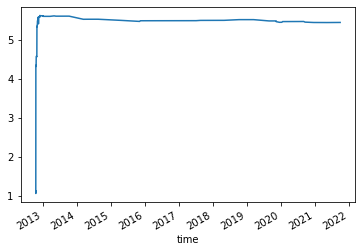

In [9]:
historical_scores['time'] =pandas.to_datetime(historical_scores.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores = historical_scores.set_index('time')
historical_scores['weighted_sum'].plot()

Cool.  It looks like the quality level of Ann Bishop came up really fast.  We can see in the output of the dataframe that there was one edit in particular where the quality jumped up in 2012.  Between [518807910 (2012-10-20T01:58:13Z)](https://en.wikipedia.org/wiki/Special:Diff/518807910) and [518838758 (2012-10-20T07:19:47Z)](https://en.wikipedia.org/wiki/Special:Diff/518838758), the quality jumped up from ~1.1 to ~4.2!  Check out [the edit that caused the change](https://en.wikipedia.org/wiki/Special:Diff/518838758).

For fun, let's try a bigger article: [Ada Lovelace](https://en.wikipedia.org/wiki/Ada_Lovelace)

In [10]:
historical_scores2 = pandas.DataFrame(fetch_scores(fetch_history("Ada Lovelace")))

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

<AxesSubplot:xlabel='time'>

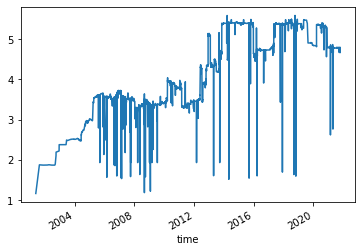

In [11]:
historical_scores2['time'] =pandas.to_datetime(historical_scores2.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores2 = historical_scores2.set_index('time')
historical_scores2['weighted_sum'].plot()

Interestingly, we can see some dips in the quality of Ada Lovelace.  I wonder what's going on there.

In [12]:
historical_scores2[
    (historical_scores2['timestamp'] >= mwtypes.Timestamp('2005-01-01T00:00:00Z')) & 
    (historical_scores2['weighted_sum'] < 3)]

,rev_id,timestamp,weighted_sum
time,,,
2005-02-07 08:11:08,10281789,2005-02-07T08:11:08Z,2.987285
2005-02-15 07:23:52,10557076,2005-02-15T07:23:52Z,2.994299
2005-02-25 09:20:03,10617475,2005-02-25T09:20:03Z,2.981951
2005-02-27 16:52:02,10742628,2005-02-27T16:52:02Z,2.981951
2005-03-03 22:03:17,10871556,2005-03-03T22:03:17Z,2.969195
...,...,...,...
2018-10-27 21:42:52,866039453,2018-10-27T21:42:52Z,1.598783
2018-11-01 14:13:19,866779266,2018-11-01T14:13:19Z,1.598495
2018-11-01 14:17:39,866779754,2018-11-01T14:17:39Z,1.598495


I wonder what happened in these edits.  Picking from the top few, let's look at [20232247](https://en.wikipedia.org/wiki/Special:Diff/20232247), [22607614](https://en.wikipedia.org/wiki/Special:Diff/22607614), and [28917096](https://en.wikipedia.org/wiki/Special:Diff/28917096).  ...and they are all vandalism.  